In [ ]:
import kagglehub
tawsifurrahman_covid19_radiography_database_path = kagglehub.dataset_download('tawsifurrahman/covid19-radiography-database')

print('Data source import complete.')


Data source import complete.


In [ ]:
import shutil
import os


# Define new path
new_path = '/content/covid19-radiography-database'

# Move dataset from cached location to new path
if not os.path.exists(new_path):
    shutil.copytree(tawsifurrahman_covid19_radiography_database_path, new_path)

print(f'Dataset moved to: {new_path}')


Dataset moved to: /content/covid19-radiography-database


# Detecting COVID-19 with Chest X Ray using Resnet



**Load and preprocess the dataset**

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.6.0+cu124


**Split training data for 5 hospitals (federated learning simulation)**

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

**Set up virtual workers (hospitals) for federated learning**

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

**Define the Vision Transformer model**

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

**Create a model copy for each worker**

In [ ]:
train_dirs = {
    'normal': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images',
    'viral': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'covid': '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples


In [ ]:
from torch.utils.data import random_split

# Total size of the dataset
total_size = len(train_dataset)

# Define split sizes, e.g., 80% train, 20% val
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Optionally, wrap in DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


In [ ]:
train_dataset = train_subset
test_dataset = val_subset

In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2021
Number of test batches 506


**Define loss function and optimizers for each worker's model**

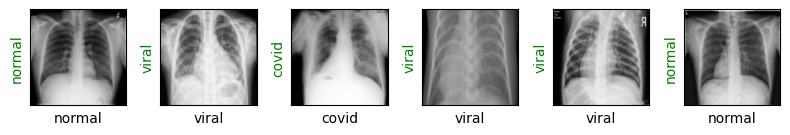

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

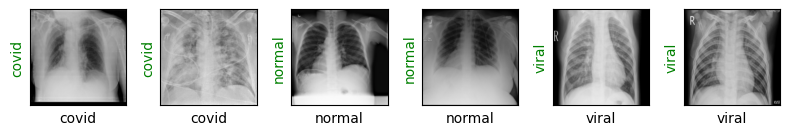

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

**Creating the Model**

In [ ]:
from torchvision.models import resnet18
resnet18 = resnet18(weights=None)


In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

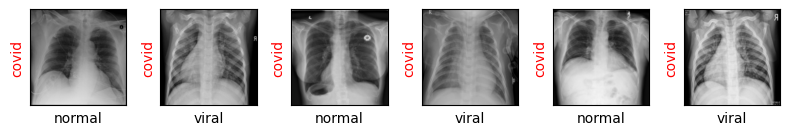

In [ ]:
show_preds()

**Train the model using federated learning**

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_accuracies = []

def train(epochs):
    print('Starting training..')
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train()

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                resnet18.eval()

                accuracy = 0
                val_loss = 0

                with torch.no_grad():
                    for val_step, (images_val, labels_val) in enumerate(dl_test):
                        outputs_val = resnet18(images_val)
                        loss_val = loss_fn(outputs_val, labels_val)
                        val_loss += loss_val.item()

                        _, preds = torch.max(outputs_val, 1)
                        accuracy += (preds == labels_val).sum().item()

                val_loss /= (val_step + 1)
                accuracy /= len(test_dataset)

                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                # Save metrics
                train_losses.append(train_loss / (train_step + 1))
                val_losses.append(val_loss)
                val_accuracies.append(accuracy)

                show_preds()
                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')


**Evaluate the global model on the test set**

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1875, Accuracy: 0.3322


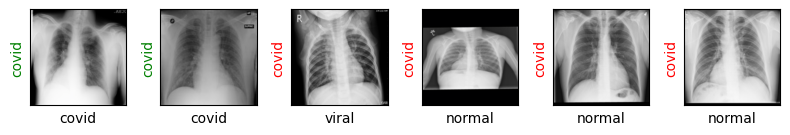

Evaluating at step 20
Validation Loss: 1.1410, Accuracy: 0.3547


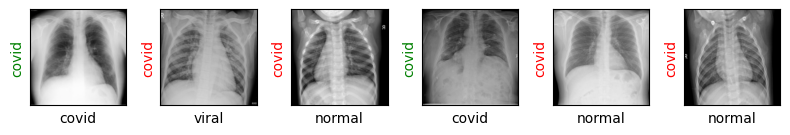

Evaluating at step 40
Validation Loss: 0.9358, Accuracy: 0.5127


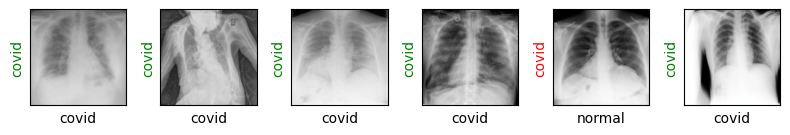

Evaluating at step 60
Validation Loss: 0.6949, Accuracy: 0.7080


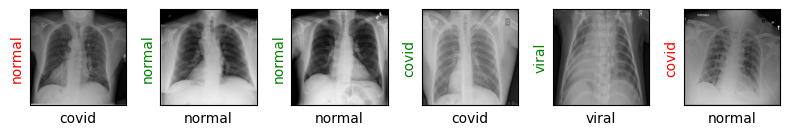

Evaluating at step 80


In [ ]:
%%time

train(epochs=1)

In [ ]:
# Plot losses
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Evaluation Step')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Evaluation Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Time')
plt.legend()

plt.tight_layout()
plt.show()


# Final Results

In [ ]:
show_preds()